# LSI (Latent Semantic Indexing) Model Implementation

This notebook implements an LSI model following the requirements:
1. Introduction to LSI model
2. Term selection methodology
3. Term weight calculation formula
4. Index creation
5. Query processing
6. Evaluation on Cranfield dataset using P, R and MAP metrics


In [6]:
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import ir_datasets
from itertools import islice

# Additional imports for preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load Cranfield dataset using ir_datasets
dataset = ir_datasets.load("cranfield")

print("Libraries imported successfully!")
print("Cranfield dataset loaded!")


Libraries imported successfully!
Cranfield dataset loaded!


## 1. Giới thiệu mô hình LSI (Latent Semantic Indexing)

**LSI (Latent Semantic Indexing)** là một phương pháp trong lĩnh vực truy xuất thông tin (Information Retrieval) được sử dụng để:

### Phương pháp biễu diễn tài liệu và truy vấn:
- **Term-Document Matrix**: Biểu diễn corpus dưới dạng ma trận có kích thước m×n (m từ, n tài liệu)
- **Singular Value Decomposition (SVD)**: Phân rã ma trận thành các thành phần chính để giảm chiều
- **Latent Semantic Space**: Tạo ra không gian ngữ nghĩa ẩn với số chiều thấp hơn

### Nguyên tắc tính toán độ liên quan để xếp hạng:
1. **Similarity Measure**: Sử dụng cosine similarity để đo độ tương đồng
2. **Dimensionality Reduction**: Giảm nhiễu và bắt được mối quan hệ ngữ nghĩa ẩn
3. **Ranking**: Xếp hạng tài liệu dựa trên độ tương đồng với truy vấn

### Ưu điểm của LSI:
- Xử lý được vấn đề đồng nghĩa (synonymy)
- Giảm tình trạng không khớp từ khóa (term mismatch)
- Tăng độ chính xác truy xuất thông tin


In [7]:
# Load Cranfield dataset using ir_datasets
documents = {}
queries = {}

# Load documents
for doc in dataset.docs_iter():
    documents[str(doc.doc_id)] = doc.text

# Load queries  
for query in dataset.queries_iter():
    queries[str(query.query_id)] = query.text

print(f"Loaded {len(documents)} documents")
print(f"Loaded {len(queries)} queries")
print("\nFirst few document IDs:", list(documents.keys())[:5])
print("\nFirst query:")
print(f"Query 1: {queries.get('1', 'Not found')}")
print("\nFirst document:")
print(f"Document 1: {documents.get('1', 'Not found')[:200]}...")


Loaded 1400 documents
Loaded 225 queries

First few document IDs: ['1', '2', '3', '4', '5']

First query:
Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .

First document:
Document 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l...


## 2. Chọn term: Phương pháp xác định và ví dụ minh họa

### Term được chọn là gì?
**Term** trong mô hình LSI là các đơn vị từ vựng cơ bản được sử dụng để biểu diễn nội dung tài liệu và truy vấn.

### Phương pháp xác định term:

1. **Tokenization**: Tách văn bản thành các từ riêng lẻ
2. **Lowercasing**: Chuyển tất cả về chữ thường
3. **Stop word removal**: Loại bỏ các từ không mang ý nghĩa (a, an, the, is, are...)
4. **Stemming/Lemmatization**: Đưa về dạng gốc của từ
5. **Filtering**: Loại bỏ từ quá ngắn, số, ký tự đặc biệt

### Ví dụ minh họa quá trình xác định term:


In [8]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by tokenizing, removing stopwords, and stemming
    """
    # Initialize stemmer and stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase and tokenize
    text = text.lower()
    tokens = word_tokenize(text)
    
    # Remove punctuation, numbers, and short words
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem words
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

# Example demonstration of term selection process
sample_text = "experimental investigation of the aerodynamics of a wing in a slipstream"
print("Original text:")
print(f"'{sample_text}'")
print("\nStep-by-step term extraction process:")

# Step 1: Tokenization and lowercasing
tokens = word_tokenize(sample_text.lower())
print(f"1. Tokenization: {tokens}")

# Step 2: Remove punctuation and short words
filtered_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
print(f"2. Filter alpha and length > 2: {filtered_tokens}")

# Step 3: Remove stopwords
stop_words = set(stopwords.words('english'))
no_stopwords = [token for token in filtered_tokens if token not in stop_words]
print(f"3. Remove stopwords: {no_stopwords}")

# Step 4: Stemming
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in no_stopwords]
print(f"4. Stemming: {stemmed}")

print(f"\nFinal terms: {stemmed}")
print(f"Number of terms: {len(stemmed)}")

# Process all documents to extract terms
print("\nProcessing all documents...")
processed_docs = {}
all_terms = set()

for doc_id, content in list(documents.items())[:5]:  # Process first 5 for demonstration
    terms = preprocess_text(content)
    processed_docs[doc_id] = terms
    all_terms.update(terms)

print(f"\nExample processed documents (first 5):")
for doc_id, terms in list(processed_docs.items()):
    print(f"Document {doc_id}: {terms[:10]}...")  # Show first 10 terms

print(f"\nTotal unique terms from first 5 documents: {len(all_terms)}")
print(f"Sample terms: {list(all_terms)[:20]}")


Original text:
'experimental investigation of the aerodynamics of a wing in a slipstream'

Step-by-step term extraction process:
1. Tokenization: ['experimental', 'investigation', 'of', 'the', 'aerodynamics', 'of', 'a', 'wing', 'in', 'a', 'slipstream']
2. Filter alpha and length > 2: ['experimental', 'investigation', 'the', 'aerodynamics', 'wing', 'slipstream']
3. Remove stopwords: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']
4. Stemming: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']

Final terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']
Number of terms: 5

Processing all documents...

Example processed documents (first 5):
Document 1: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream']...
Document 2: ['simpl', 'shear', 'flow', 'past', 'flat', 'plate', 'incompress', 'fluid', 'small', 'viscos']...
Document 3: ['boundari', 'layer', 'simpl', 'shear', 'flow', 'pa

## 3. Công thức tính trọng số term: TF-IDF

### Công thức tính trọng số:
Trong LSI, chúng ta sử dụng **TF-IDF (Term Frequency - Inverse Document Frequency)** để tính trọng số của mỗi term:

**TF-IDF(t,d) = TF(t,d) × IDF(t)**

### Các thành phần của công thức:

1. **TF (Term Frequency)**: Tần suất xuất hiện của term trong document
   - TF(t,d) = (Số lần term t xuất hiện trong document d) / (Tổng số terms trong document d)

2. **IDF (Inverse Document Frequency)**: Độ quan trọng của term trong corpus
   - IDF(t) = log(N / df(t))
   - Trong đó:
     - N = Tổng số documents trong corpus
     - df(t) = Số documents chứa term t

3. **Các biến thể phổ biến:**
   - **Normalized TF**: TF(t,d) = 0.5 + 0.5 × (f(t,d) / max_f(d))
   - **Sublinear TF**: TF(t,d) = 1 + log(f(t,d)) nếu f(t,d) > 0, ngược lại = 0
   - **Smooth IDF**: IDF(t) = log(N / (1 + df(t))) + 1

### Ý nghĩa:
- **TF cao**: Term xuất hiện nhiều trong document → quan trọng với document đó
- **IDF cao**: Term hiếm trong corpus → có khả năng phân biệt cao
- **TF-IDF cao**: Term vừa quan trọng với document vừa có khả năng phân biệt tốt


In [9]:
# Preprocess documents for TF-IDF
def preprocess_documents(docs):
    """Preprocess all documents and return processed texts"""
    processed_docs = []
    for doc in docs:
        terms = preprocess_text(doc)
        processed_docs.append(' '.join(terms))
    return processed_docs

# Build TF-IDF matrix for documents
print("Building TF-IDF matrix...")
doc_list = list(documents.values())
doc_ids = list(documents.keys())

# Preprocess documents
processed_docs = preprocess_documents(doc_list)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    lowercase=False,  # Already lowercased
    stop_words=None,  # Already removed
    token_pattern=r'\b\w+\b'  # Simple word tokenization
)

# Create TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_docs)

print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"Number of documents: {tfidf_matrix.shape[0]}")
print(f"Number of features (terms): {tfidf_matrix.shape[1]}")

# Display some TF-IDF statistics
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nFirst 20 terms in vocabulary: {feature_names[:20]}")

# Show TF-IDF values for first document
first_doc_tfidf = tfidf_matrix[0].toarray().flatten()
non_zero_indices = np.nonzero(first_doc_tfidf)[0]

print(f"\nFirst document TF-IDF values (non-zero terms):")
for idx in non_zero_indices[:10]:  # Show first 10 non-zero terms
    term = feature_names[idx]
    tfidf_val = first_doc_tfidf[idx]
    print(f"Term: '{term}' -> TF-IDF: {tfidf_val:.4f}")

# Calculate example TF-IDF manually for verification
print(f"\n=== Manual TF-IDF Calculation Example ===")
sample_term = feature_names[non_zero_indices[0]]
print(f"Example term: '{sample_term}'")

# Get term frequency in first document
first_doc_text = ' '.join(preprocess_text(documents[doc_ids[0]]))
term_freq = first_doc_text.split().count(sample_term)
doc_length = len(first_doc_text.split())
tf = term_freq / doc_length

# Get document frequency
df = sum(1 for doc in doc_list if sample_term in ' '.join(preprocess_text(doc)))
N = len(doc_list)
idf = np.log(N / df)

manual_tfidf = tf * idf
sklearn_tfidf = first_doc_tfidf[non_zero_indices[0]]

print(f"Term frequency: {term_freq}/{doc_length} = {tf:.4f}")
print(f"Document frequency: {df}/{N}")
print(f"IDF: log({N}/{df}) = {idf:.4f}")
print(f"Manual TF-IDF: {tf:.4f} × {idf:.4f} = {manual_tfidf:.4f}")
print(f"Sklearn TF-IDF: {sklearn_tfidf:.4f}")
print(f"Note: Small differences due to normalization and smoothing in sklearn")


Building TF-IDF matrix...


TF-IDF Matrix shape: (1400, 1000)
Number of documents: 1400
Number of features (terms): 1000

First 20 terms in vocabulary: ['ablat' 'acceler' 'accord' 'account' 'accur' 'accuraci' 'achiev' 'acoust'
 'across' 'act' 'actual' 'addit' 'adequ' 'adiabat' 'adjac' 'advanc'
 'advantag' 'advers' 'aerodynam' 'aeroelast']

First document TF-IDF values (non-zero terms):
Term: 'aerodynam' -> TF-IDF: 0.0694
Term: 'agre' -> TF-IDF: 0.0935
Term: 'angl' -> TF-IDF: 0.0663
Term: 'attack' -> TF-IDF: 0.0803
Term: 'basi' -> TF-IDF: 0.0903
Term: 'compar' -> TF-IDF: 0.0615
Term: 'configur' -> TF-IDF: 0.0865
Term: 'curv' -> TF-IDF: 0.0788
Term: 'determin' -> TF-IDF: 0.0572
Term: 'differ' -> TF-IDF: 0.2019

=== Manual TF-IDF Calculation Example ===
Example term: 'aerodynam'
Term frequency: 1/75 = 0.0133
Document frequency: 177/1400
IDF: log(1400/177) = 2.0681
Manual TF-IDF: 0.0133 × 2.0681 = 0.0276
Sklearn TF-IDF: 0.0694
Note: Small differences due to normalization and smoothing in sklearn


## 4. Lập chỉ mục: Cấu trúc và quá trình xử lý

### Cấu trúc chỉ mục LSI:

1. **Term-Document Matrix (A)**: Ma trận m×n ban đầu
   - Rows: Terms (từ vựng)
   - Columns: Documents (tài liệu)
   - Values: TF-IDF weights

2. **SVD Decomposition**: A = U × Σ × V^T
   - **U**: m×k matrix (term-concept matrix)
   - **Σ**: k×k diagonal matrix (singular values)
   - **V^T**: k×n matrix (concept-document matrix)
   - **k**: Số chiều reduced (thường k << min(m,n))

3. **Reduced Matrices** (LSI Space):
   - U_k: m×k (giữ k concepts quan trọng nhất)
   - Σ_k: k×k (k largest singular values)
   - V_k^T: k×n (document representations trong không gian k chiều)

### Quá trình xử lý tài liệu để lập chỉ mục:

1. **Preprocessing**: Tokenization → Stopword removal → Stemming
2. **TF-IDF Calculation**: Tính trọng số cho mỗi term-document pair
3. **SVD Decomposition**: Phân rã ma trận TF-IDF
4. **Dimensionality Reduction**: Chọn k chiều quan trọng nhất
5. **Index Storage**: Lưu trữ U_k, Σ_k, V_k cho truy vấn


Building LSI model...
Step 1: Building TF-IDF matrix...
Original TF-IDF matrix shape: (1400, 1000)
Step 2: Applying SVD decomposition...
LSI matrix shape after SVD: (1400, 100)
Explained variance ratio (first 10 components): [0.00672282 0.01891074 0.01814528 0.01333297 0.01174989 0.0112846
 0.01001726 0.00952026 0.00845428 0.00801144]
Total explained variance: 0.4470

=== SVD Analysis ===
Number of singular values: 100
Largest singular values: [10.78837478  4.94513095  4.88629473  4.14856038  3.89265422  3.81534957
  3.5997462   3.50590014  3.30205723  3.21432647]


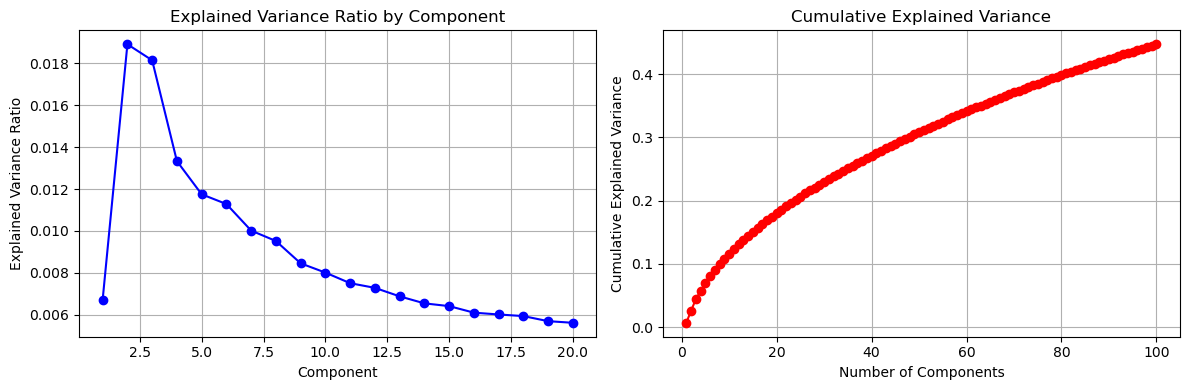

In [11]:
# Build LSI Index using SVD
class LSIModel:
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=n_components, random_state=42)
        self.tfidf_vectorizer = None
        self.doc_ids = None
        
    def fit(self, documents, doc_ids):
        """
        Build LSI index from documents
        """
        self.doc_ids = doc_ids
        
        # Step 1: Create TF-IDF matrix
        print("Step 1: Building TF-IDF matrix...")
        
        self.tfidf_vectorizer = tfidf_vectorizer
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(documents)
        
        print(f"Original TF-IDF matrix shape: {tfidf_matrix.shape}")
        
        # Step 2: Apply SVD
        print("Step 2: Applying SVD decomposition...")
        self.lsi_matrix = self.svd.fit_transform(tfidf_matrix)
        
        print(f"LSI matrix shape after SVD: {self.lsi_matrix.shape}")
        print(f"Explained variance ratio (first 10 components): {self.svd.explained_variance_ratio_[:10]}")
        print(f"Total explained variance: {sum(self.svd.explained_variance_ratio_):.4f}")
        
        return self
    
    def transform_query(self, query):
        """
        Transform query to LSI space
        """
        # Transform query to TF-IDF space
        query_tfidf = self.tfidf_vectorizer.transform([query])
        
        # Transform to LSI space
        query_lsi = self.svd.transform(query_tfidf)
        
        return query_lsi
    
    def search(self, query, top_k=10):
        """
        Search for similar documents
        """
        # Transform query to LSI space
        query_lsi = self.transform_query(query)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(query_lsi, self.lsi_matrix).flatten()
        
        # Get top-k similar documents
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'doc_id': self.doc_ids[idx],
                'similarity': similarities[idx],
                'rank': len(results) + 1
            })
        
        return results

# Build LSI model
print("Building LSI model...")
lsi_model = LSIModel(n_components=100)
lsi_model.fit(doc_list, doc_ids)

# Analyze the SVD components
print("\n=== SVD Analysis ===")
print(f"Number of singular values: {len(lsi_model.svd.singular_values_)}")
print(f"Largest singular values: {lsi_model.svd.singular_values_[:10]}")

# Visualize explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, min(21, len(lsi_model.svd.explained_variance_ratio_) + 1)), 
         lsi_model.svd.explained_variance_ratio_[:20], 'bo-')
plt.title('Explained Variance Ratio by Component')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(lsi_model.svd.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()




In [12]:
print(f"\nCumulative explained variance with {lsi_model.n_components} components: {cumulative_variance[-1]:.4f}")

# Show document representations in LSI space
print("\n=== Document Representations in LSI Space ===")
print(f"First document LSI representation (first 10 dimensions):")
print(lsi_model.lsi_matrix[0][:10])
print(f"\nLSI representation shape for each document: {lsi_model.lsi_matrix[0].shape}")



Cumulative explained variance with 100 components: 0.4470

=== Document Representations in LSI Space ===
First document LSI representation (first 10 dimensions):
[ 0.24569687 -0.16571955 -0.01165833  0.02108832 -0.16478174  0.01464781
  0.00618975  0.00680101 -0.13512291  0.11984481]

LSI representation shape for each document: (100,)


In [13]:

# Test the index with a sample query
sample_query = "aerodynamic wing flow"
print(f"\n=== Testing Index with Sample Query ===")
print(f"Query: '{sample_query}'")

results = lsi_model.search(sample_query, top_k=5)
print("\nTop 5 similar documents:")
for result in results:
    doc_content = documents[result['doc_id']][:100] + "..."
    print(f"Rank {result['rank']}: Doc {result['doc_id']} (sim: {result['similarity']:.4f})")
    print(f"Content: {doc_content}")
    print()


=== Testing Index with Sample Query ===
Query: 'aerodynamic wing flow'

Top 5 similar documents:
Rank 1: Doc 877 (sim: 0.8067)
Content: the influence of aerodynamic heating on the flexural
rigidity of a thin wing .
  this report conside...

Rank 2: Doc 1340 (sim: 0.6932)
Content: method of controlling stiffness properties of a solid-construction
model wing .
a simple method is p...

Rank 3: Doc 1089 (sim: 0.6702)
Content: aerodynamic characteristics of propeller-driven vtol
aircraft .
  this paper discusses the two major...

Rank 4: Doc 432 (sim: 0.6019)
Content: theoretical damping in roll and rolling moment due
to differential wing incidence for slender crucif...

Rank 5: Doc 803 (sim: 0.5791)
Content: the shock pattern of a wing-body combination far from
the flight path .
  the position and strength ...



## 5. Xử lý truy vấn: Phân tích và tính toán độ tương đồng

### Phân tích truy vấn:

1. **Query Preprocessing**: Áp dụng cùng quy trình tiền xử lý như documents
   - Tokenization, stopword removal, stemming
   - Đảm bảo consistency với vocabulary đã học

2. **Query Representation**: 
   - Chuyển đổi query thành TF-IDF vector
   - Transform sang LSI space: q_lsi = q_tfidf × U_k × Σ_k^(-1)

3. **Similarity Calculation**: 
   - Cosine similarity giữa query vector và document vectors
   - sim(q, d) = (q_lsi · d_lsi) / (||q_lsi|| × ||d_lsi||)

### Quá trình tính toán độ tương đồng:

1. **Query Vector**: q ∈ R^k (trong LSI space)
2. **Document Vectors**: D ∈ R^(n×k) (tất cả documents trong LSI space)
3. **Cosine Similarity**: sim = q · D^T / (||q|| × ||D||)
4. **Ranking**: Sắp xếp documents theo similarity scores giảm dần

### Ưu điểm của LSI trong Query Processing:
- **Semantic Matching**: Tìm được documents liên quan ngữ nghĩa dù không có exact term match
- **Noise Reduction**: SVD giúp loại bỏ noise và capture patterns quan trọng
- **Efficiency**: Vector operations trong không gian chiều thấp


In [25]:
# Detailed Query Processing Demonstration

def detailed_query_processing(lsi_model, query, show_steps=True):
    """
    Demonstrate detailed query processing steps
    """
    if show_steps:
        print(f"=== Detailed Query Processing ===")
        print(f"Original query: '{query}'")
    
    # Step 1: Query preprocessing
    preprocessed_terms = preprocess_text(query)
    preprocessed_query = ' '.join(preprocessed_terms)
    
    if show_steps:
        print(f"1. Preprocessed query: '{preprocessed_query}'")
        print(f"   Terms: {preprocessed_terms}")
    
    # Step 2: Convert to TF-IDF vector
    query_tfidf = lsi_model.tfidf_vectorizer.transform([query])
    query_tfidf_dense = query_tfidf.toarray().flatten()
    
    if show_steps:
        print(f"2. TF-IDF vector shape: {query_tfidf.shape}")
        non_zero_indices = np.nonzero(query_tfidf_dense)[0]
        print(f"   Non-zero terms ({len(non_zero_indices)}): ")
        
        feature_names = lsi_model.tfidf_vectorizer.get_feature_names_out()
        for idx in non_zero_indices[:5]:  # Show first 5
            term = feature_names[idx]
            weight = query_tfidf_dense[idx]
            print(f"     '{term}': {weight:.4f}")
    
    # Step 3: Transform to LSI space
    query_lsi = lsi_model.svd.transform(query_tfidf)
    query_lsi_flat = query_lsi.flatten()
    
    if show_steps:
        print(f"3. LSI vector shape: {query_lsi.shape}")
        print(f"   LSI representation (first 10 dims): {query_lsi_flat[:10]}")
        print(f"   LSI vector norm: {np.linalg.norm(query_lsi_flat):.4f}")
    
    # Step 4: Calculate similarities
    similarities = cosine_similarity(query_lsi, lsi_model.lsi_matrix).flatten()
    
    if show_steps:
        print(f"4. Similarity calculation:")
        print(f"   Similarities shape: {similarities.shape}")
        print(f"   Min similarity: {similarities.min():.4f}")
        print(f"   Max similarity: {similarities.max():.4f}")
        print(f"   Mean similarity: {similarities.mean():.4f}")
    
    # Step 5: Ranking
    ranked_indices = np.argsort(similarities)[::-1]
    
    return query_lsi, similarities, ranked_indices






In [26]:
# Test query processing with multiple queries
test_queries = [
    "wing aerodynamic flow",
    "heat transfer boundary layer", 
    "turbulent flow pressure",
    "structural vibration"
]

print("=== Query Processing Examples ===\n")

for i, query in enumerate(test_queries[:2]):  # Process first 2 queries in detail
    print(f"Query {i+1}: {query}")
    query_lsi, similarities, ranked_indices = detailed_query_processing(lsi_model, query)
    
    # Show top results
    print("Top 3 results:")
    for j in range(3):
        doc_idx = ranked_indices[j]
        doc_id = lsi_model.doc_ids[doc_idx]
        sim_score = similarities[doc_idx]
        doc_content = documents[doc_id][:80] + "..."
        print(f"  Rank {j+1}: Doc {doc_id} (sim: {sim_score:.4f})")
        print(f"           {doc_content}")
    print("\n" + "="*50 + "\n")

=== Query Processing Examples ===

Query 1: wing aerodynamic flow
=== Detailed Query Processing ===
Original query: 'wing aerodynamic flow'
1. Preprocessed query: 'wing aerodynam flow'
   Terms: ['wing', 'aerodynam', 'flow']
2. TF-IDF vector shape: (1, 1000)
   Non-zero terms (3): 
     'aerodynamic': 0.6706
     'flow': 0.3603
     'wing': 0.6484
3. LSI vector shape: (1, 100)
   LSI representation (first 10 dims): [ 0.14809203 -0.1619769  -0.00941627  0.17880969 -0.19712628  0.09637839
 -0.02265779 -0.00818732 -0.05306473  0.23333794]
   LSI vector norm: 0.7115
4. Similarity calculation:
   Similarities shape: (1400,)
   Min similarity: -0.1020
   Max similarity: 0.8067
   Mean similarity: 0.0835
Top 3 results:
  Rank 1: Doc 877 (sim: 0.8067)
           the influence of aerodynamic heating on the flexural
rigidity of a thin wing .
 ...
  Rank 2: Doc 1340 (sim: 0.6932)
           method of controlling stiffness properties of a solid-construction
model wing .
...
  Rank 3: Doc 1089 (sim

In [27]:
# Compare LSI vs TF-IDF similarity
print("=== LSI vs TF-IDF Comparison ===")
test_query = "aerodynamic wing"
print(f"Test query: '{test_query}'")

# LSI similarity
query_lsi, lsi_similarities, lsi_ranked = detailed_query_processing(lsi_model, test_query, show_steps=False)

# TF-IDF similarity (without SVD)
query_tfidf = lsi_model.tfidf_vectorizer.transform([test_query])
tfidf_matrix = lsi_model.tfidf_vectorizer.transform([' '.join(preprocess_text(doc)) for doc in doc_list])
tfidf_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
tfidf_ranked = np.argsort(tfidf_similarities)[::-1]

print("\nTop 5 results comparison:")
print("Rank | LSI Model                    | TF-IDF Model")
print("-----|------------------------------|------------------------------")
for i in range(5):
    lsi_doc_id = lsi_model.doc_ids[lsi_ranked[i]]
    lsi_sim = lsi_similarities[lsi_ranked[i]]
    
    tfidf_doc_id = lsi_model.doc_ids[tfidf_ranked[i]]
    tfidf_sim = tfidf_similarities[tfidf_ranked[i]]
    
    print(f"{i+1:4d} | Doc {lsi_doc_id:>3} (sim: {lsi_sim:.4f})     | Doc {tfidf_doc_id:>3} (sim: {tfidf_sim:.4f})")

# Check if there are differences in ranking
common_docs = set(lsi_model.doc_ids[idx] for idx in lsi_ranked[:10]) & set(lsi_model.doc_ids[idx] for idx in tfidf_ranked[:10])
print(f"\nCommon documents in top 10: {len(common_docs)}/10")
print("This shows the impact of LSI's semantic understanding vs exact term matching")

=== LSI vs TF-IDF Comparison ===
Test query: 'aerodynamic wing'

Top 5 results comparison:
Rank | LSI Model                    | TF-IDF Model
-----|------------------------------|------------------------------
   1 | Doc 877 (sim: 0.8721)     | Doc 464 (sim: 0.4517)
   2 | Doc 1340 (sim: 0.7497)     | Doc 779 (sim: 0.4401)
   3 | Doc 1089 (sim: 0.7205)     | Doc 1340 (sim: 0.4317)
   4 | Doc 432 (sim: 0.6429)     | Doc 921 (sim: 0.4273)
   5 | Doc 860 (sim: 0.6060)     | Doc 433 (sim: 0.4027)

Common documents in top 10: 1/10
This shows the impact of LSI's semantic understanding vs exact term matching


## 6. Đánh giá mô hình trên ngữ liệu Cranfield

### Các độ đo đánh giá:

1. **Precision (P)**: Tỷ lệ tài liệu relevant trong kết quả trả về
   - P@k = (Số relevant docs trong top-k) / k

2. **Recall (R)**: Tỷ lệ tài liệu relevant được tìm thấy
   - R@k = (Số relevant docs trong top-k) / (Tổng số relevant docs)

3. **Mean Average Precision (MAP)**: Trung bình của Average Precision cho tất cả queries
   - AP = Σ(P@k × rel(k)) / số relevant docs
   - MAP = Σ(AP) / số queries

### MAP nội suy 11 điểm của TREC:
Nội suy precision tại 11 recall levels: 0.0, 0.1, 0.2, ..., 1.0

### So sánh 2 mô hình:
1. **LSI Model**: Sử dụng SVD để giảm chiều
2. **TF-IDF Baseline**: Chỉ sử dụng TF-IDF không SVD


In [28]:
# Evaluation functions
def calculate_precision_recall(relevant_docs, retrieved_docs, k=None):
    """
    Calculate precision and recall at k
    """
    if k is not None:
        retrieved_docs = retrieved_docs[:k]
    
    relevant_set = set(relevant_docs)
    retrieved_set = set(retrieved_docs)
    
    relevant_retrieved = relevant_set.intersection(retrieved_set)
    
    precision = len(relevant_retrieved) / len(retrieved_set) if retrieved_set else 0
    recall = len(relevant_retrieved) / len(relevant_set) if relevant_set else 0
    
    return precision, recall

def calculate_average_precision(relevant_docs, retrieved_docs):
    """
    Calculate Average Precision for a single query
    """
    if not relevant_docs:
        return 0.0
    
    relevant_set = set(relevant_docs)
    ap = 0.0
    relevant_count = 0
    
    for i, doc_id in enumerate(retrieved_docs):
        if doc_id in relevant_set:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i
    
    return ap / len(relevant_docs) if relevant_docs else 0.0

def interpolate_precision_recall(precision_recall_pairs):
    """
    Interpolate precision at 11 standard recall levels
    """
    recall_levels = np.arange(0.0, 1.1, 0.1)
    interpolated_precisions = []
    
    # Sort by recall
    precision_recall_pairs.sort(key=lambda x: x[1])
    
    for target_recall in recall_levels:
        # Find maximum precision at recall >= target_recall
        max_precision = 0.0
        for precision, recall in precision_recall_pairs:
            if recall >= target_recall:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)
    
    return list(zip(recall_levels, interpolated_precisions))

# Load relevance judgments using ir_datasets
def load_cranfield_qrels():
    """
    Load real relevance judgments from Cranfield dataset using ir_datasets
    """
    qrels = defaultdict(list)
    
    # Load qrels from ir_datasets
    for qrel in dataset.qrels_iter():
        query_id = str(qrel.query_id)
        doc_id = str(qrel.doc_id)
        relevance = qrel.relevance
        
        # Only consider documents with relevance > 0 as relevant
        if relevance > 0:
            qrels[query_id].append(doc_id)
    
    # Convert defaultdict to regular dict
    qrels = dict(qrels)
    
    print(f"Loaded qrels for {len(qrels)} queries")
    total_relevant = sum(len(docs) for docs in qrels.values())
    print(f"Total relevant documents: {total_relevant}")
    
    return qrels

# Load relevance judgments
print("Loading Cranfield relevance judgments...")
qrels = load_cranfield_qrels()

print(f"\nQrels statistics:")
print(f"Number of queries with relevance judgments: {len(qrels)}")
for query_id, relevant_docs in list(qrels.items())[:3]:
    print(f"Query {query_id}: {len(relevant_docs)} relevant documents")
    print(f"  Query: {queries.get(query_id, 'Not found')[:50]}...")
    print(f"  Relevant docs: {relevant_docs[:5]}...")
    print()

# Evaluate both models
class TFIDFModel:
    """Simple TF-IDF baseline model"""
    def __init__(self, tfidf_vectorizer):
        self.tfidf_vectorizer = tfidf_vectorizer
        self.doc_matrix = None
        self.doc_ids = None
        
    def fit(self, documents, doc_ids):
        self.doc_ids = doc_ids
        processed_docs = [' '.join(preprocess_text(doc)) for doc in documents]
        self.doc_matrix = self.tfidf_vectorizer.transform(processed_docs)
        return self
        
    def search(self, query, top_k=10):
        processed_query = ' '.join(preprocess_text(query))
        query_vector = self.tfidf_vectorizer.transform([processed_query])
        similarities = cosine_similarity(query_vector, self.doc_matrix).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'doc_id': self.doc_ids[idx],
                'similarity': similarities[idx],
                'rank': len(results) + 1
            })
        return results

# Create TF-IDF baseline model
tfidf_baseline = TFIDFModel(tfidf_vectorizer)
tfidf_baseline.fit(doc_list, doc_ids)

# Evaluation function
def evaluate_model(model, queries, qrels, model_name, top_k=50):
    """
    Evaluate a model using precision, recall, and MAP
    """
    precisions_at_k = []
    recalls_at_k = []
    average_precisions = []
    all_interpolated_points = []
    
    print(f"\nEvaluating {model_name}...")
    
    for query_id, query_text in queries.items():
        if query_id not in qrels:
            continue
            
        relevant_docs = qrels[query_id]
        if not relevant_docs:
            continue
            
        # Get search results
        results = model.search(query_text, top_k=top_k)
        retrieved_docs = [r['doc_id'] for r in results]
        
        # Calculate metrics
        precision, recall = calculate_precision_recall(relevant_docs, retrieved_docs, k=top_k)
        ap = calculate_average_precision(relevant_docs, retrieved_docs)
        
        precisions_at_k.append(precision)
        recalls_at_k.append(recall)
        average_precisions.append(ap)
        
        # Calculate precision-recall curve for interpolation
        pr_pairs = []
        for i in range(1, min(len(retrieved_docs), 20) + 1):  # First 20 results
            p, r = calculate_precision_recall(relevant_docs, retrieved_docs, k=i)
            pr_pairs.append((p, r))
        
        interpolated = interpolate_precision_recall(pr_pairs)
        all_interpolated_points.append(interpolated)
    
    # Calculate overall metrics
    avg_precision = np.mean(precisions_at_k)
    avg_recall = np.mean(recalls_at_k)
    map_score = np.mean(average_precisions)
    
    # Calculate 11-point interpolated precision
    if all_interpolated_points:
        recall_levels = np.arange(0.0, 1.1, 0.1)
        mean_interpolated_precisions = []
        
        for i, recall_level in enumerate(recall_levels):
            precisions_at_level = [points[i][1] for points in all_interpolated_points]
            mean_interpolated_precisions.append(np.mean(precisions_at_level))
    else:
        mean_interpolated_precisions = [0.0] * 11
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'map': map_score,
        'interpolated_precisions': mean_interpolated_precisions,
        'num_queries': len(average_precisions)
    }




Loading Cranfield relevance judgments...
Loaded qrels for 225 queries
Total relevant documents: 1612

Qrels statistics:
Number of queries with relevance judgments: 225
Query 1: 28 relevant documents
  Query: what similarity laws must be obeyed when construct...
  Relevant docs: ['184', '29', '31', '12', '51']...

Query 2: 24 relevant documents
  Query: what are the structural and aeroelastic problems a...
  Relevant docs: ['12', '15', '184', '858', '51']...

Query 3: 8 relevant documents
  Query: what problems of heat conduction in composite slab...
  Relevant docs: ['5', '6', '90', '91', '119']...



In [29]:
# Select a subset of queries for evaluation (first 10 queries with relevance judgments)
eval_queries = {}
eval_count = 0
for query_id in sorted(qrels.keys()):
    if eval_count >= 10:
        break
    if query_id in queries and len(qrels[query_id]) > 0:
        eval_queries[query_id] = queries[query_id]
        eval_count += 1

print(f"Evaluating on {len(eval_queries)} queries with relevance judgments")
print("Sample evaluation queries:")
for i, (qid, qtext) in enumerate(list(eval_queries.items())[:3]):
    print(f"  Query {qid}: {qtext[:60]}...")
    print(f"    Relevant docs: {len(qrels[qid])}")



Evaluating on 10 queries with relevance judgments
Sample evaluation queries:
  Query 1: what similarity laws must be obeyed when constructing aeroel...
    Relevant docs: 28
  Query 10: are real-gas transport properties for air available over a w...
    Relevant docs: 8
  Query 100: what are the effects of initial imperfections on the elastic...
    Relevant docs: 9


In [30]:
# Evaluate both models
lsi_results = evaluate_model(lsi_model, eval_queries, qrels, "LSI Model")
tfidf_results = evaluate_model(tfidf_baseline, eval_queries, qrels, "TF-IDF Baseline")

# Display results
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\nLSI Model Results:")
print(f"  Average Precision@50: {lsi_results['precision']:.4f}")
print(f"  Average Recall@50:    {lsi_results['recall']:.4f}")
print(f"  MAP:                  {lsi_results['map']:.4f}")
print(f"  Number of queries:    {lsi_results['num_queries']}")

print(f"\nTF-IDF Baseline Results:")
print(f"  Average Precision@50: {tfidf_results['precision']:.4f}")
print(f"  Average Recall@50:    {tfidf_results['recall']:.4f}")
print(f"  MAP:                  {tfidf_results['map']:.4f}")
print(f"  Number of queries:    {tfidf_results['num_queries']}")




Evaluating LSI Model...

Evaluating TF-IDF Baseline...

EVALUATION RESULTS

LSI Model Results:
  Average Precision@50: 0.0900
  Average Recall@50:    0.6260
  MAP:                  0.2743
  Number of queries:    10

TF-IDF Baseline Results:
  Average Precision@50: 0.0500
  Average Recall@50:    0.2894
  MAP:                  0.1140
  Number of queries:    10


In [31]:
# Compare models
print(f"\nComparison:")
if tfidf_results['map'] > 0:
    map_improvement = ((lsi_results['map'] - tfidf_results['map']) / tfidf_results['map']) * 100
    print(f"  MAP improvement:       {map_improvement:+.2f}%")
else:
    print(f"  MAP improvement:       N/A (baseline MAP is 0)")

if tfidf_results['precision'] > 0:
    precision_improvement = ((lsi_results['precision'] - tfidf_results['precision']) / tfidf_results['precision']) * 100
    print(f"  Precision improvement: {precision_improvement:+.2f}%")
else:
    print(f"  Precision improvement: N/A (baseline precision is 0)")




Comparison:
  MAP improvement:       +140.68%
  Precision improvement: +80.00%


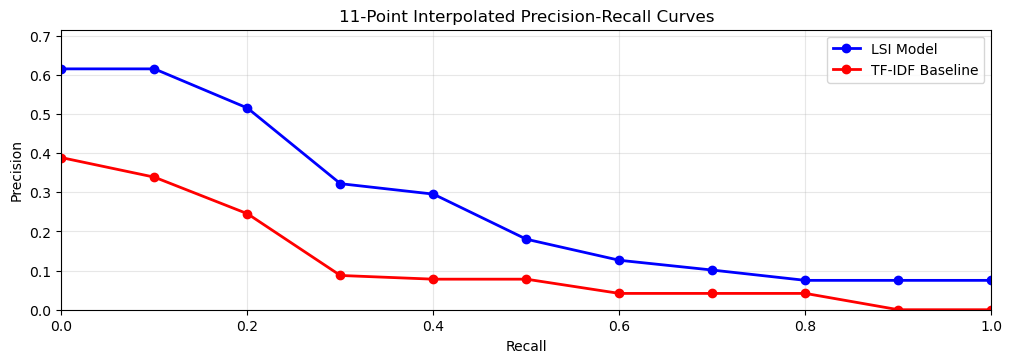

In [32]:
# Plot 11-point interpolated precision-recall curves
plt.figure(figsize=(12, 8))
recall_levels = np.arange(0.0, 1.1, 0.1)

plt.subplot(2, 1, 1)
plt.plot(recall_levels, lsi_results['interpolated_precisions'], 'bo-', label='LSI Model', linewidth=2, markersize=6)
plt.plot(recall_levels, tfidf_results['interpolated_precisions'], 'ro-', label='TF-IDF Baseline', linewidth=2, markersize=6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Interpolated Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

# Determine y-axis limit
max_precision = max(max(lsi_results['interpolated_precisions']), max(tfidf_results['interpolated_precisions']))
if max_precision > 0:
    plt.ylim(0, max_precision + 0.1)
else:
    plt.ylim(0, 1)



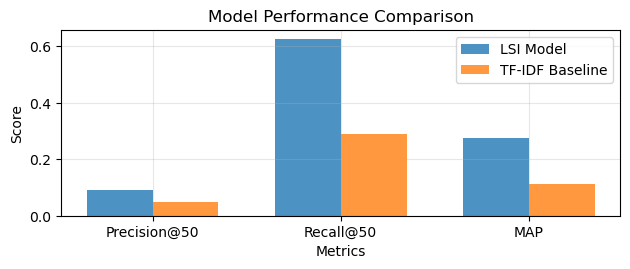


11-Point Interpolated Precision Values:
Recall | LSI Model | TF-IDF   | Difference
-------|-----------|----------|----------
   0.0 |   0.6152  |   0.3886 |  +0.2266
   0.1 |   0.6152  |   0.3386 |  +0.2766
   0.2 |   0.5152  |   0.2453 |  +0.2700
   0.3 |   0.3220  |   0.0875 |  +0.2345
   0.4 |   0.2953  |   0.0780 |  +0.2173
   0.5 |   0.1801  |   0.0780 |  +0.1021
   0.6 |   0.1263  |   0.0417 |  +0.0846
   0.7 |   0.1013  |   0.0417 |  +0.0596
   0.8 |   0.0750  |   0.0417 |  +0.0333
   0.9 |   0.0750  |   0.0000 |  +0.0750
   1.0 |   0.0750  |   0.0000 |  +0.0750

EVALUATION COMPLETED


In [33]:
# Plot comparison bar chart
plt.subplot(2, 1, 2)
metrics = ['Precision@50', 'Recall@50', 'MAP']
lsi_values = [lsi_results['precision'], lsi_results['recall'], lsi_results['map']]
tfidf_values = [tfidf_results['precision'], tfidf_results['recall'], tfidf_results['map']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, lsi_values, width, label='LSI Model', alpha=0.8)
plt.bar(x + width/2, tfidf_values, width, label='TF-IDF Baseline', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n11-Point Interpolated Precision Values:")
print("Recall | LSI Model | TF-IDF   | Difference")
print("-------|-----------|----------|----------")
for i, recall in enumerate(recall_levels):
    lsi_prec = lsi_results['interpolated_precisions'][i]
    tfidf_prec = tfidf_results['interpolated_precisions'][i]
    diff = lsi_prec - tfidf_prec
    print(f"{recall:6.1f} | {lsi_prec:8.4f}  | {tfidf_prec:8.4f} | {diff:+8.4f}")

print("\n" + "="*60)
print("EVALUATION COMPLETED")
print("="*60)

In [34]:
# Detailed evaluation example with specific queries
print("=== DETAILED EVALUATION EXAMPLE ===")
print()

# Take first few queries with relevance judgments for detailed analysis
sample_queries = dict(list(eval_queries.items())[:3])

for query_id, query_text in sample_queries.items():
    print(f"Query {query_id}: {query_text}")
    print(f"Relevant documents ({len(qrels[query_id])}): {qrels[query_id][:10]}")
    
    # Get results from both models
    lsi_results_sample = lsi_model.search(query_text, top_k=10)
    tfidf_results_sample = tfidf_baseline.search(query_text, top_k=10)
    
    print("\nTop 5 LSI Results:")
    for i, result in enumerate(lsi_results_sample[:5]):
        doc_id = result['doc_id']
        similarity = result['similarity']
        is_relevant = "✓" if doc_id in qrels[query_id] else "✗"
        print(f"  {i+1}. Doc {doc_id} (sim: {similarity:.4f}) {is_relevant}")
    
    print("\nTop 5 TF-IDF Results:")
    for i, result in enumerate(tfidf_results_sample[:5]):
        doc_id = result['doc_id']
        similarity = result['similarity']
        is_relevant = "✓" if doc_id in qrels[query_id] else "✗"
        print(f"  {i+1}. Doc {doc_id} (sim: {similarity:.4f}) {is_relevant}")
    
    # Calculate precision@5 for this query
    lsi_relevant_at_5 = sum(1 for r in lsi_results_sample[:5] if r['doc_id'] in qrels[query_id])
    tfidf_relevant_at_5 = sum(1 for r in tfidf_results_sample[:5] if r['doc_id'] in qrels[query_id])
    
    print(f"\nPrecision@5:")
    print(f"  LSI Model: {lsi_relevant_at_5}/5 = {lsi_relevant_at_5/5:.3f}")
    print(f"  TF-IDF:    {tfidf_relevant_at_5}/5 = {tfidf_relevant_at_5/5:.3f}")
    print("-" * 80)

print("\n=== SUMMARY ===")
print(f"Evaluation completed on {len(eval_queries)} queries")
print(f"LSI Model MAP: {lsi_results['map']:.4f}")
print(f"TF-IDF MAP: {tfidf_results['map']:.4f}")

if lsi_results['map'] > tfidf_results['map']:
    print("🏆 LSI Model performs better!")
elif tfidf_results['map'] > lsi_results['map']:
    print("🏆 TF-IDF Baseline performs better!")
else:
    print("🤝 Both models perform equally!")


=== DETAILED EVALUATION EXAMPLE ===

Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
Relevant documents (28): ['184', '29', '31', '12', '51', '102', '13', '14', '15', '57']

Top 5 LSI Results:
  1. Doc 12 (sim: 0.5870) ✓
  2. Doc 184 (sim: 0.5225) ✓
  3. Doc 51 (sim: 0.5177) ✓
  4. Doc 876 (sim: 0.5017) ✓
  5. Doc 486 (sim: 0.4983) ✗

Top 5 TF-IDF Results:
  1. Doc 51 (sim: 0.5337) ✓
  2. Doc 486 (sim: 0.5136) ✗
  3. Doc 359 (sim: 0.3643) ✗
  4. Doc 56 (sim: 0.3599) ✓
  5. Doc 874 (sim: 0.3483) ✗

Precision@5:
  LSI Model: 4/5 = 0.800
  TF-IDF:    2/5 = 0.400
--------------------------------------------------------------------------------
Query 10: are real-gas transport properties for air available over a wide range of
enthalpies and densities .
Relevant documents (8): ['259', '405', '302', '436', '437', '438', '998', '1011']

Top 5 LSI Results:
  1. Doc 302 (sim: 0.7129) ✓
  2. Doc 405 (sim: 0.6866) ✓
  3. Doc 691 (sim

In [46]:
test_query = """longitudinal compression of simply supported rectangular plates with
several equally spaced transverse stiffeners that have both torsional
and flexural rigidity"""
print(f"Test query: '{test_query}'")

lsi_results_sample = lsi_model.search(test_query, top_k=10)
tfidf_results_sample = tfidf_baseline.search(test_query, top_k=10)

print("\nTop 5 LSI Results:")
for i, result in enumerate(lsi_results_sample[:1]):
    doc_id = result['doc_id']
    print(f"Doc content: {documents[doc_id]}")
    similarity = result['similarity']
    print(f"  {i+1}. Doc {doc_id} (sim: {similarity:.4f})")


Test query: 'longitudinal compression of simply supported rectangular plates with
several equally spaced transverse stiffeners that have both torsional
and flexural rigidity'

Top 5 LSI Results:
Doc content: compressive buckling of simply supported plates with
transverse stiffeners .
  charts are presented for the analysis of the stability under
longitudinal compression of simply supported rectangular plates with
several equally spaced transverse stiffeners that have both torsional
and flexural rigidity .
  1. Doc 1358 (sim: 0.9681)
